## Deep Q-Learning 네트워크(DQN)
* 큐 러닝에 딥러닝 신경망을 적용한 것
* 구글 딥마인드 "Playing Atari with Deep Reinforcement Learning"
<br> - 전통적인 큐러닝의 큐테이블을 딥러닝 신경망으로 대체해서 아타리(Atari) 고전게임을 성공적으로 플레이하는 에이전트를 발표했음
* 큐러닝의 문제점인 관찰 상태와 행동에 큐테이블의 크기가 영향을 받는다는 문제점을 해결함
---
### [2048 게임](https://kil500.tistory.com/236)
* 16개의 타일공간(관찰 상태)에 있는 숫자들을 상하좌우로 움직여서(행동), 2048이라는 숫자를 만드는 것이 목표임
* 게임 규칙
<br> - 게임이 시작할 때 총 2개의 타일이 생성됨 : 90% 확률로 2 숫자타일, 10% 확률로 4 숫자타일
<br> - 상하좌우 4방향으로 게임판의 모든 타일을 움직일 수 있으며, 움직일 때 같은 숫자를 만나면 합쳐짐
<br> - 타일을 합치면 합친만큼의 개수의 새 타일을 얻을 수 있고 점수에도 추가됨
<br> - 타일을 합치거나 이동시키는 등의 유효한 행동을 한 뒤에는 랜덤한 타일 하나가 빈 공간에 생성됨
<br> - 더 이상 타일을 생성할 수 없을 때 게임이 종료됨
---
### 2048 게임을 위한 메모리 공간 크기
* 행동의 개수 : 4 (0:좌, 1:상, 2:우, 3: 하)
* 관찰 공간 수 : 16(4x4)개 x 12가지 = 12^16 = 1.8 x 10^17
<br> - 타일의 종류(12가지) :  0(빈공간), 1, 2, 4, 8, 16, .., 2^10, 2^20 
* 모든 관찰 공간에 대해 Q값을 계산을 위한 총 메모리 필요량
<br> - 관찰 공간의 수 x 행동의 개수 = 2.9 x 10^18 (2.9 EB)
---
### DQN의 장점
* 기존 큐러닝의 단점을 보완
<br> - 전통적인 큐러닝으로 학습할 경우 큐테이블에 저장하고 계산해야 할 양이 너무 많음
<br> - 이런 단점을 보완하기 위해 딥 큐러닝 네트워크로 큐테이블을 대체할 수 있음
* Experience Replay를 사용한 성능 향상
<br> - 큐러닝은 환경을 실행하며 얻어지는 데이터로 즉시 학습했지만, DQN은 별도의 메모리에 데이터를 저장한 뒤에 어느 정도의 데이터가 쌓이면 랜덤한 샘플을 뽑아서 학습시킴

In [1]:
colab = 1
debug = 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm lab
!ln -s /content/drive/MyDrive/lab-rla/ch4/ lab
!ls -l

total 8
drwx------ 5 root root 4096 Jul 16 04:00 drive
lrwxrwxrwx 1 root root   35 Jul 16 04:00 lab -> /content/drive/MyDrive/lab-rla/ch4/
drwxr-xr-x 1 root root 4096 Jul  1 13:42 sample_data


In [5]:
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# 텐서플로 2 버전 선택
# try:
#     # %tensorflow_version only exists in Colab.
#     %tensorflow_version 2.x
# except Exception:
#     pass
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.5.0


In [7]:
if colab:
    !pip install gym pyvirtualdisplay
    !apt-get install -y xvfb python-opengl ffmpeg

    !apt-get update
    !apt-get install cmake
    !pip install --upgrade setuptools
    !pip install ez_setup
    !pip install gym[atari]

    !pip install box2d-py
    !pip install gym[Box_2D]
else:
#     pip install gym
    pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 1,281 kB in 1s (980 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64

  Created wheel for ez-setup: filename=ez_setup-0.9-cp37-none-any.whl size=11014 sha256=198c10d31ad19a79595353dfeefda8402450c2d8a0fa37cf9f55aa0a61a049a3
  Stored in directory: /root/.cache/pip/wheels/dc/e8/6b/3d5ff5a3efd7b5338d1e173ac981771e2628ceb2f7866d49ad
Successfully built ez-setup
     |████████████████████████████████| 450kB 8.1MB/s 


### Experiance Replay가 효율적인 이유 살펴보기

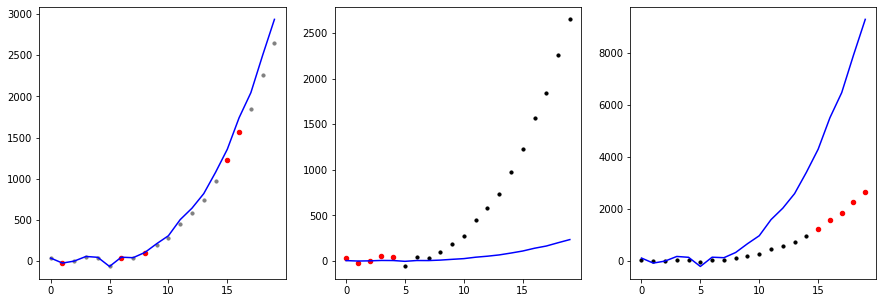

In [5]:
# Linear Regression 예 
# 그림 : 데이터 중 랜덤하게 5개를 선택했을 때(왼쪽), 처음 다섯개를 선택했을 때(중간), 마지막 다섯개를 선택했을 때(오른쪽)의 회귀 분석 결과 차이
# some code from https://towardsdatascience.com/polynomial-regression-bbe8b9d97491
# some other code from https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

np.random.seed(0)
x = np.array(range(20))
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-40, 40, 20)
x = np.reshape(x, (-1, 1))
y = np.reshape(y, (-1, 1))

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(x,y, s=10, color='gray')

select = np.random.choice(20, 5, replace=False)
select.sort()
clf = Ridge(alpha=100, normalize=True)
clf.fit(x[select], y[select])

plt.scatter(x[select], y[select], s=20, color='r')
plt.plot(x, clf.predict(y) - clf.intercept_, color='blue')


plt.subplot(1, 3, 2)
plt.scatter(x,y, s=10, color='k')

select = np.array(range(5))
clf = Ridge(alpha=100, normalize=True)
clf.fit(x[select], y[select])

plt.scatter(x[select], y[select], s=20, color='r')
plt.plot(x, clf.predict(y) - clf.intercept_, color='blue')


plt.subplot(1, 3, 3)
plt.scatter(x,y, s=10, color='k')

select = np.array(range(15, 20))
clf = Ridge(alpha=100, normalize=True)
clf.fit(x[select], y[select])

plt.scatter(x[select], y[select], s=20, color='r')
plt.plot(x, clf.predict(y) - clf.intercept_, color='blue')

plt.show()

In [6]:
# gym_2048 설치
!pip install gym_2048 --no-dependencies

  Created wheel for gym-2048: filename=gym_2048-0.2.6-cp37-none-any.whl size=4699 sha256=79810e29ced20f35b7c0332d22b713e80b13744468d27cb2fbb4bd3edd966649
  Stored in directory: /root/.cache/pip/wheels/ab/11/22/a6c0fb3622f6fad7e8b7f4342a3c64e115bee08a4189bbae18
Successfully built gym-2048


In [7]:
# gym_2048 환경 확인
import gym_2048
import gym

env = gym.make('2048-v0')
obs = env.reset()

print(obs)
print(env.observation_space)
print(env.action_space)

obs, _, _, _ = env.step(0)  # 행동의 개수 : 4 (0:좌, 1:상, 2:우, 3: 하)
print(obs)
obs, _, _, _ = env.step(0)  # 행동의 개수 : 4 (0:좌, 1:상, 2:우, 3: 하)
print(obs)

[[2 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
Box(2, 4294967296, (4, 4), int64)
Discrete(4)
[[2 2 0 0]
 [0 0 0 0]
 [2 0 0 0]
 [0 0 0 0]]
[[4 0 0 0]
 [0 0 0 2]
 [2 0 0 0]
 [0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [8]:
# 랜덤 행동 에이전트의 실행 결과 확인
score = 0
step = 0
obs = env.reset()
if debug: print(f'==>start_obs:\n{obs}')
while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if debug: print(f'-->action:{action}, reward:{reward}, done:{done}, obs:\n{obs}')
    
    score += reward
    step += 1
    if done:        break
        
print('score:', score, 'step:', step)
print(obs)

==>start_obs:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 2 0]]
-->action:1, reward:0, done:False, obs:
[[0 0 2 2]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
-->action:3, reward:4, done:False, obs:
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 4 2]]
-->action:2, reward:0, done:False, obs:
[[4 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 4 2]]
-->action:1, reward:4, done:False, obs:
[[4 0 4 4]
 [0 0 0 0]
 [0 0 0 0]
 [0 2 0 0]]
-->action:2, reward:8, done:False, obs:
[[0 0 4 8]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 2]]
-->action:1, reward:0, done:False, obs:
[[0 2 4 8]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]]
-->action:2, reward:0, done:False, obs:
[[0 2 4 8]
 [0 0 0 2]
 [0 0 0 2]
 [0 2 0 0]]
-->action:3, reward:8, done:False, obs:
[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 8]
 [0 4 4 4]]
-->action:0, reward:8, done:False, obs:
[[0 0 2 0]
 [0 0 0 0]
 [2 8 0 0]
 [8 4 0 0]]
-->action:0, reward:0, done:False, obs:
[[2 0 0 0]
 [0 0 0 0]
 [2 8 2 0]
 [8 4 0 0]]
-->action:3, reward:4, done:False, obs:
[[0 0 0 0]
 [0 0 2 0]
 [4 8 0 0]
 [8 4 2 0]]
-->act

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [9]:
# 2048 게임 보드의 원-핫 인코딩 함수(알파고)
layer_count = 12
table = {2**i:i for i in range(layer_count)}
print(table)

def preprocess(obs):    
    x = np.zeros((4, 4, layer_count))
    for i in range(4):
        for j in range(4):
            if obs[i,j] > 0:
                v = min(obs[i,j], 2**(layer_count-1))
                x[i,j,table[v]] = 1
            else:
                x[i,j,0] = 1
    return x

{1: 0, 2: 1, 4: 2, 8: 3, 16: 4, 32: 5, 64: 6, 128: 7, 256: 8, 512: 9, 1024: 10, 2048: 11}


### DQN Network 설계
* DQN은 하나가 아닌 2개의 큐네트워크를 사용함 : model, target_model
* 두 네트워크의 구조는 동일함
* Q값 계산식
<br> Q(s,a) = Q(s,a) + a(알파) * (R + r*maxQ(s',a') - Q(s,a))

In [10]:
# Q-Network 모델 정의 함수
def build_model():
    dense1 = 128
    dense2 = 128

    x = tf.keras.Input(shape=(4, 4, layer_count))

    conv_a = tf.keras.layers.Conv2D(dense1, kernel_size=(2,1), activation='relu')(x)
    conv_b = tf.keras.layers.Conv2D(dense1, kernel_size=(1,2), activation='relu')(x)
    if debug: print(f'conv_a:{conv_a.shape}, conv_b:{conv_b.shape}')

    conv_aa = tf.keras.layers.Conv2D(dense2, kernel_size=(2,1), activation='relu')(conv_a)
    conv_ab = tf.keras.layers.Conv2D(dense2, kernel_size=(1,2), activation='relu')(conv_a)
    conv_ba = tf.keras.layers.Conv2D(dense2, kernel_size=(2,1), activation='relu')(conv_b)
    conv_bb = tf.keras.layers.Conv2D(dense2, kernel_size=(1,2), activation='relu')(conv_b)
    if debug: 
        print(f'conv_aa:{conv_aa.shape}, conv_ab:{conv_ab.shape}')
        print(f'conv_ba:{conv_ba.shape}, conv_bb:{conv_bb.shape}')

    flat = [tf.keras.layers.Flatten()(a) for a in [conv_a, conv_b, conv_aa, conv_ab, conv_ba, conv_bb]]    

    concat = tf.keras.layers.Concatenate()(flat)
    if debug: print(f'concat:{concat.shape}')
        
    dense1 = tf.keras.layers.Dense(256, activation='relu')(concat)
    out = tf.keras.layers.Dense(4, activation='linear')(dense1)

    model = tf.keras.Model(inputs=x, outputs=out)
    model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.0005), loss='mse')
    return model

model = build_model()
target_model = build_model()

conv_a:(None, 3, 4, 128), conv_b:(None, 4, 3, 128)
conv_aa:(None, 2, 4, 128), conv_ab:(None, 3, 3, 128)
conv_ba:(None, 3, 3, 128), conv_bb:(None, 4, 2, 128)
concat:(None, 7424)
conv_a:(None, 3, 4, 128), conv_b:(None, 4, 3, 128)
conv_aa:(None, 2, 4, 128), conv_ab:(None, 3, 3, 128)
conv_ba:(None, 3, 3, 128), conv_bb:(None, 4, 2, 128)
concat:(None, 7424)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 12)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 4, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 4, 128)    32896       conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
# 학습 함수 정의
gamma = 0.9
batch_size = 512
max_memory = batch_size*8
memory = []

def append_sample(state, action, reward, next_state, done):
    memory.append([state, action, reward, next_state, done])

def train_model():
    np.random.shuffle(memory)

    len = max_memory // batch_size
    for k in range(len):
        mini_batch = memory[k*batch_size:(k+1)*batch_size]

        states = np.zeros((batch_size, 4, 4, layer_count))
        next_states = np.zeros((batch_size, 4, 4, layer_count))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = model.predict(states)
        next_target = target_model.predict(next_states)

        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                # Q(s,a) = Q(s,a) + a(알파) * (R + r*maxQ(s',a') - Q(s,a))
                target[i][actions[i]] = rewards[i] + gamma * np.amax(next_target[i])

        model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

In [13]:
%%time
# local-gpu : 약 25분 20초, colab : 약  분 --> ep 1000
# local-gpu : 약 분, colab : 약 2분 --> ep 100
# DQN 학습
import gym_2048
import gym
import math
import random
env = gym.make('2048-v0')

max_episodes = 101  # 5001
epsilon = 0.9
epsilon_min = 0.1

scores = []
steps = []
iteration = 0
train_count = 0

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

for i in range(max_episodes):
    if i % 100 == 0 and i != 0:
        print('score mean:', np.mean(scores[-100:]), 'step mean:', np.mean(steps[-100:]), 'iteration:', iteration, 'epsilon:', epsilon)

    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])
    prev_max = np.max(prev_obs)

    while True:
        iteration += 1

        # epsilon-greedy policy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            x = preprocess(prev_obs)
            logits = model.predict(np.expand_dims(x, axis=0))[0]
            prob = softmax(logits)
            prob = prob * not_move_list
            action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        # custom reward
        now_max = np.max(obs)
        if prev_max < now_max:
            prev_max = now_max
            reward = math.log(now_max, 2) * 0.1  # log(val, base)
        else:
            reward = 0

        reward += np.count_nonzero(prev_obs) - np.count_nonzero(obs) + 1

        append_sample(preprocess(prev_obs), action, reward, preprocess(obs), done)

        if len(memory) >= max_memory:
            train_model()
            memory = []

            train_count += 1
            if train_count % 4 == 0:
                target_model.set_weights(model.get_weights())

        prev_obs = obs

#         if epsilon > 0.01 and iteration % 2500 == 0:
        if epsilon > 0.01 and iteration % 500 == 0:
            epsilon = epsilon / 1.005

        if done:            break

    scores.append(score)
    steps.append(step)

    if i % 100 == 0 and i != 0:
      print(i, 'score:', score, 'step:', step, 'max tile:', np.max(obs), 'memory len:', len(memory))

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


score mean: 963.0 step mean: 113.63 iteration: 11363 epsilon: 0.8064717346996236
100 score: 1072 step: 121 max tile: 128 memory len: 2887
CPU times: user 1min 8s, sys: 3.25 s, total: 1min 11s
Wall time: 1min 39s


In [14]:
!ls -F

drive/	lab@  sample_data/


In [17]:
model.save('lab/2048-conv6.h5')
# model.save('lab/2048-conv6')

INFO:tensorflow:Assets written to: lab/2048-conv6/assets


In [19]:
# !ls -l lab
!ls -l lab/2048-conv6

total 278
drwx------ 2 root root   4096 Jul 16 04:05 assets
-rw------- 1 root root  30967 Jul 16 04:05 keras_metadata.pb
-rw------- 1 root root 245135 Jul 16 04:05 saved_model.pb
drwx------ 2 root root   4096 Jul 16 04:05 variables


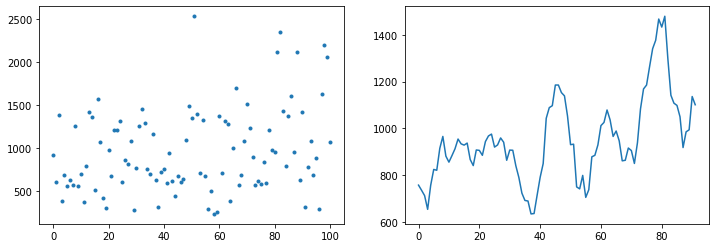

In [20]:
# 점수 확인
import matplotlib.pyplot as plt

N = 10
rolling_mean = [np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(scores)), scores, marker='.')
plt.subplot(1, 2, 2)
plt.plot(rolling_mean)
plt.show()

### Kernel Restart 후 아래의 게임 테스트 실행 시 사용 

In [21]:
import gym_2048
import gym
import math
import random

from tensorflow.keras.models import load_model
model = load_model('lab/2048-conv6.h5')
target_model = load_model('lab/2048-conv6.h5')
# model = load_model('lab/2048-conv6')
# target_model = load_model('lab/2048-conv6')
model.summary()
env = gym.make('2048-v0')

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 12)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 4, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 3, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 4, 128)    32896       conv2d[0][0]                     
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [22]:
%%time
# local-gpu : 약 6분 21초, colab : 약  분 --> 100
# local-gpu : 약 분, colab : 약 3분 --> 50
# 게임 테스트
test_scores = []
max_tile = {}
iteration = 0
train_count = 0

# for i in range(1000):
for i in range(51):
    prev_obs = env.reset()

    score = 0
    step = 0
    not_move_list = np.array([1,1,1,1])

    while True:
        iteration += 1

        x = preprocess(prev_obs)
        logits = model.predict(np.expand_dims(x, axis=0))[0]
        prob = softmax(logits)
        prob = prob * not_move_list
        action = np.argmax(prob)

        obs, reward, done, info = env.step(action)

        score += reward
        step += 1

        # not moved situation
        if reward == 0 and np.array_equal(obs, prev_obs):
            not_move_list[action] = 0
            continue
        else:
            not_move_list = np.array([1,1,1,1])

        prev_obs = obs

        if done:
            now_max = np.max(obs)
            max_tile[now_max] = max_tile.get(now_max, 0) + 1
            break

    test_scores.append(score)
    print(i, 'score:', score, 'step:', step, 'max tile:', np.max(obs))

print(max_tile)

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 score: 1368 step: 151 max tile: 128
1 score: 1660 step: 187 max tile: 128
2 score: 1492 step: 174 max tile: 128
3 score: 908 step: 120 max tile: 64
4 score: 1080 step: 118 max tile: 128
5 score: 1656 step: 182 max tile: 128
6 score: 912 step: 104 max tile: 128
7 score: 708 step: 96 max tile: 64
8 score: 572 step: 81 max tile: 64
9 score: 1740 step: 185 max tile: 128
10 score: 284 step: 54 max tile: 32
11 score: 292 step: 62 max tile: 32
12 score: 772 step: 101 max tile: 64
13 score: 972 step: 121 max tile: 64
14 score: 960 step: 103 max tile: 128
15 score: 1156 step: 126 max tile: 128
16 score: 2584 step: 234 max tile: 256
17 score: 1888 step: 190 max tile: 128
18 score: 792 step: 107 max tile: 64
19 score: 596 step: 84 max tile: 64
20 score: 624 step: 87 max tile: 64
21 score: 1756 step: 184 max tile: 128
22 score: 716 step: 94 max tile: 64
23 score: 1580 step: 155 max tile: 128
24 score: 416 step: 72 max tile: 32
25 score: 1164 step: 127 max tile: 128
26 score: 5348 step: 388 max t